In [1]:
# --- Auto-reload packages when code changes (no kernel restart needed) ---
try:
    # For Jupyter/IPython environments
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
    print("🔄 Autoreload enabled: code changes will be auto-reloaded!")
except Exception as e:
    print("⚠️ Could not enable autoreload (not in IPython/Jupyter?):", e)


🔄 Autoreload enabled: code changes will be auto-reloaded!


In [2]:
# Clean solution: Auto-add project root to path
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['image.cmap'] = 'cividis'

# Get the project root (parent directory of examples/)
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now import everything cleanly
from DynaSD import GIN, NDD, LiNDDA, MINDD, IMPRINT, WVNT, LiRNDDA, ABSSLP, HFER

import numpy as np
import pandas as pd
import scipy as sc

from tests.synthetic_data_generator import SyntheticSeizureGenerator

print("✅ DynaSD imported successfully!")
print(f"📁 Project root: {project_root}")
print(f"🐍 Using Python: {sys.executable}")

# Verify the imports work
print(f"📦 GIN class: {GIN}")
print(f"📦 NDD class: {NDD}")

✅ DynaSD imported successfully!
📁 Project root: /Users/wojemann/Documents/CNT/DynaSD
🐍 Using Python: /Users/wojemann/Documents/CNT/DynaSD/dynasd_env/bin/python
📦 GIN class: <class 'DynaSD.GIN.GIN'>
📦 NDD class: <class 'DynaSD.NDD.NDD'>


In [21]:
fs = 256
generator = SyntheticSeizureGenerator(fs=fs, random_seed=42)

data,sz_start,sz_end = generator.generate_combined_signal(baseline_duration=20, seizure_duration=10, seizure_type='focal', n_channels=4, focal_channels=list(range(8)), transition_duration=0)


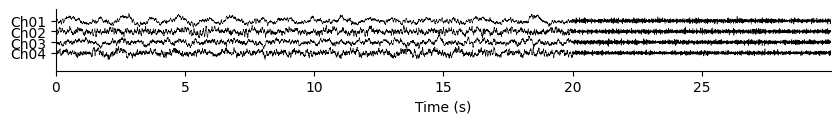

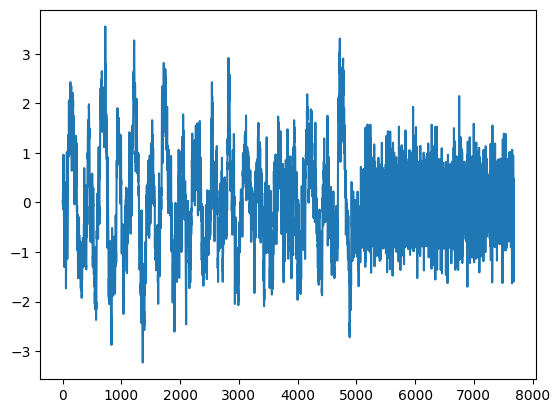

In [22]:
from example_utils import plot_iEEG_data
plot_iEEG_data(data,fs=fs)
plt.show()
plt.plot(data[['Ch01']])
plt.show()

In [34]:
sequence_length = 8
forecast_length = 1
model = GIN(num_epochs=100,batch_size=128,num_stacks=1,sequence_length = sequence_length,forecast_length=forecast_length,hidden_size=data.shape[1],early_stopping=True, num_layers=1,lr=0.01,w_stride=0.5,w_size=1,patience=2)
# model = LiRNDDA(num_epochs=200,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,hidden_size=2*data.shape[1],early_stopping=True, num_layers=2,lr=0.0005,w_stride=0.125,w_size=1,patience=2)

# model = LiNDDA(num_epochs=200,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,early_stopping=True,lr=0.0005,w_stride=0.125,w_size=1,val_split=0.1)
# model = MINDD(num_epochs=100,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,early_stopping=True,lr=
# 0.0005,dropout=0.2,hidden_sizes=[sequence_length*data.shape[1]]*3,w_stride=0.125,w_size=1,patience=1,)
model.fit(data.iloc[:fs*10,:])

  Model: MultiStepGRU(
  (gru): GRU(4, 4, batch_first=True)
  (input_projection): Linear(in_features=4, out_features=4, bias=True)
  (input_stack): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
  (projection): Linear(in_features=4, out_features=4, bias=True)
)
  Parameters: 189
Training MultiStepGRU model:
  Sequence length: 8, Forecast length: 1
  Early stopping: True
  Model parameters: 189
  DataLoader workers: 8
Creating 2552 non-overlapping sequences from continuous data
  Training sequences: 2042, Validation sequences: 510
Starting training...


Training:  19%|█▉        | 19/100 [00:03<00:15,  5.25it/s, train_loss=0.0667, val_loss=0.0645, patience=2]


Early stopping triggered after 20 epochs
Creating 2552 non-overlapping sequences from continuous data


Training completed


In [35]:
ndd = model(data)
mse = model.mse_df.to_numpy()
mse_z = model.mse_z_df.to_numpy()
prob_times = model.get_win_times(len(data))
onset_idx = np.argmin(np.abs(prob_times-sz_start))//2

Creating 7672 non-overlapping sequences from continuous data


Creating 7672 non-overlapping sequences from continuous data


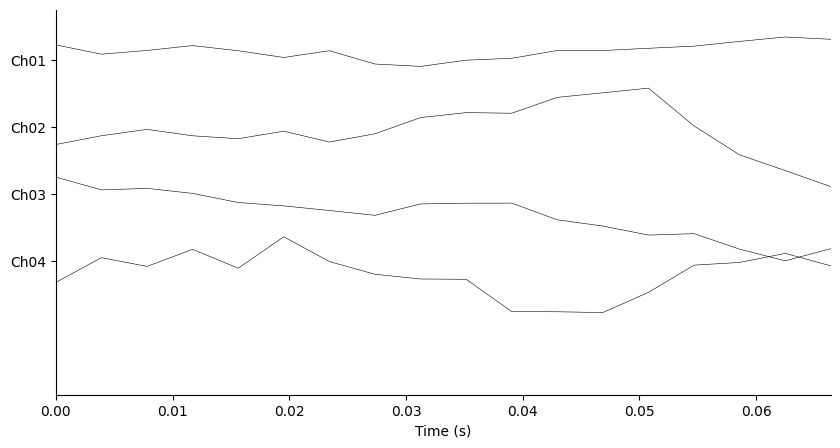

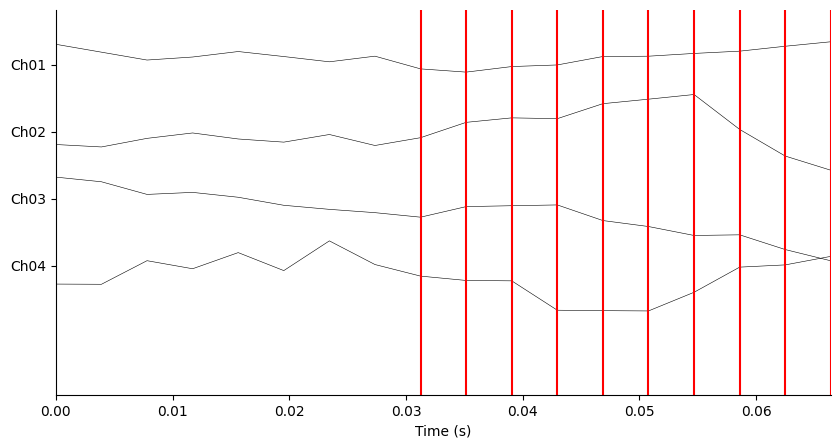

In [36]:
# forecast_length = 32
# model.forecast_length = 1
x = model.predict(data.iloc[:,:])
s = 10*fs
length = forecast_length*10 + sequence_length
plot_iEEG_data(data.iloc[s:s+length,:],fs=fs,fig_size=(10,5))
plt.show()
fig,ax = plot_iEEG_data(pd.DataFrame(x,columns=data.columns).iloc[s:s+length,:],fs=fs,fig_size=(10,5))
for v in range(10):
    ax.axvline((v*forecast_length+sequence_length)/fs,color='r')
plt.show()

Creating 2553 non-overlapping sequences from continuous data
Creating 7672 non-overlapping sequences from continuous data


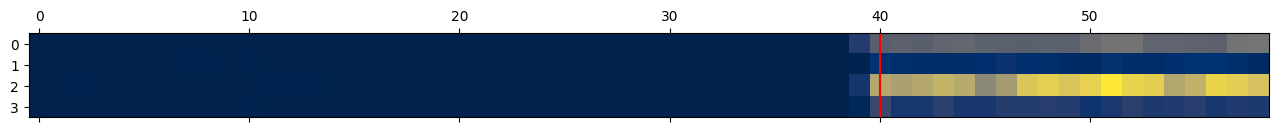

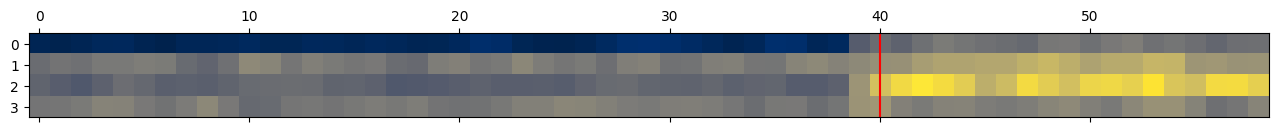

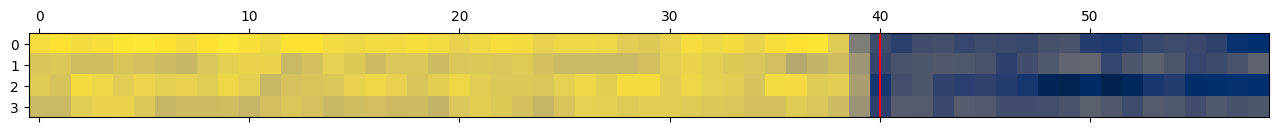

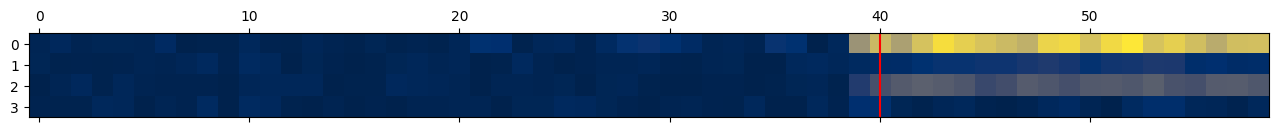

Creating 7672 non-overlapping sequences from continuous data


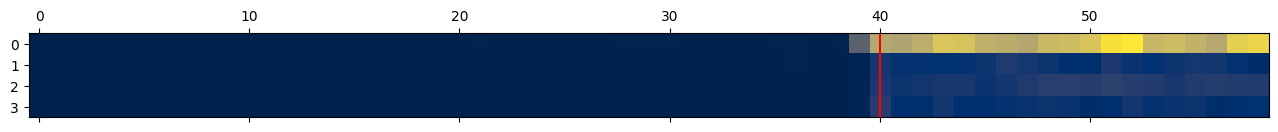

Creating 7672 non-overlapping sequences from continuous data


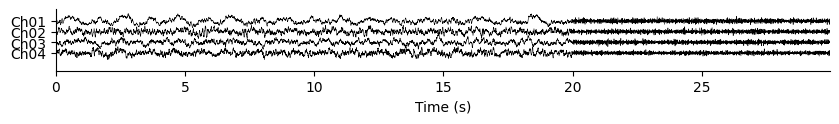

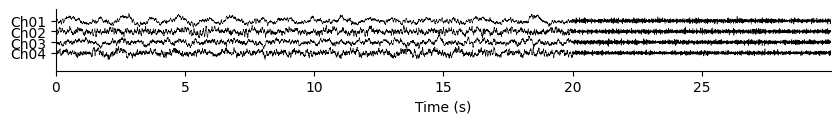

[[1.         0.93825037]
 [0.93825037 1.        ]]


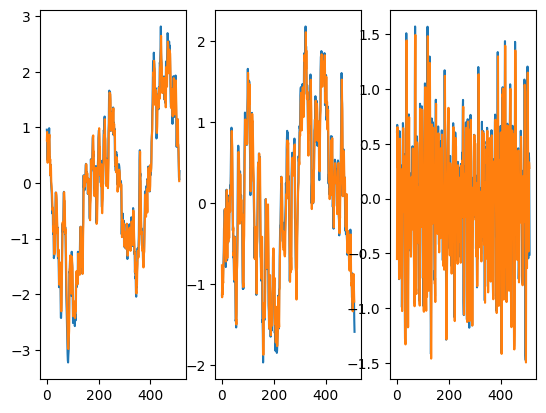

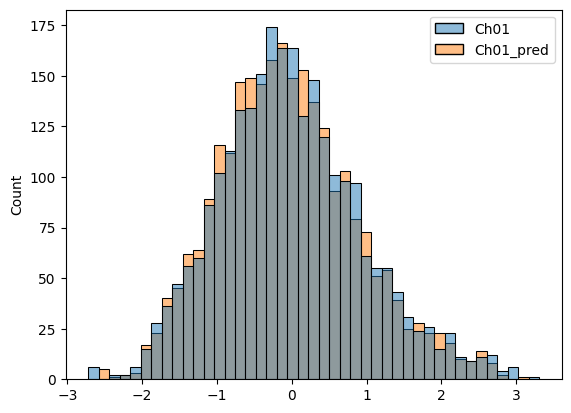

In [37]:
from math import nan


prob_times = model.get_win_times(len(data))
onset_idx = np.argmin(np.abs(prob_times-sz_start))//2
mse,corr = model._get_features(data.iloc[:fs*10+1,:])
train_idx = len(mse)

ndd = model(data)
mse = model.mse_df.to_numpy()
mse_z = model.mse_z_df.to_numpy()
corr = model.corr_df.to_numpy()
XY = np.concatenate((mse.reshape(mse.shape[0],mse.shape[1],1),corr.reshape(corr.shape[0],corr.shape[1],1)),axis=2).transpose(1,0,2)
# XY = mse.reshape(mse.shape[0],mse.shape[1],1).transpose(1,0,2)
X = XY[:,train_idx:train_idx+20,:]
Y = XY[:,train_idx+20:,:]

mahalanobis = np.zeros(corr[:,:].shape)
for i in range(X.shape[0]):
    x = X[i,:,:].reshape(-1,X.shape[2])
    y = XY[i,:,:].reshape(-1,XY.shape[2])
    m = np.mean(x, axis=0)
    C = x - m
    _, R = np.linalg.qr(C) 
    ri = np.linalg.solve(R.T, (y - m).T)
    mahalanobis[:,i] = np.sum(ri * ri, axis=0) * (x.shape[0] - 1)

for mat in [mahalanobis,mse,corr,np.abs(mse_z)]:
    plt.matshow(mat.T)
    # plt.colorbar()
    plt.axvline(x=onset_idx*2,color='r')
    plt.show()
ndd = model(data)
plt.matshow(ndd.T)
plt.axvline(x=onset_idx*2,color='r')
plt.show()

x = model.predict(data)
nan_mask = np.isnan(x).sum(axis=1)==0
plot_iEEG_data(pd.DataFrame(x,columns=data.columns).loc[nan_mask,:],fs=fs)
plot_iEEG_data(data,fs=fs)
plt.show()


print(np.corrcoef(x[fs*10:fs*20,:].reshape(1,-1),data.iloc[fs*10:fs*20,:].to_numpy().reshape(1,-1)))
s = 5*fs
plt.subplot(1,3,1)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
s = 15*fs
plt.subplot(1,3,2)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
s = 20*fs
plt.subplot(1,3,3)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
plt.show()

sns.histplot((data['Ch01'][10*fs:20*fs],pd.DataFrame(x,columns=data.columns+'_pred').loc[10*fs:20*fs,'Ch01_pred']))
plt.show()


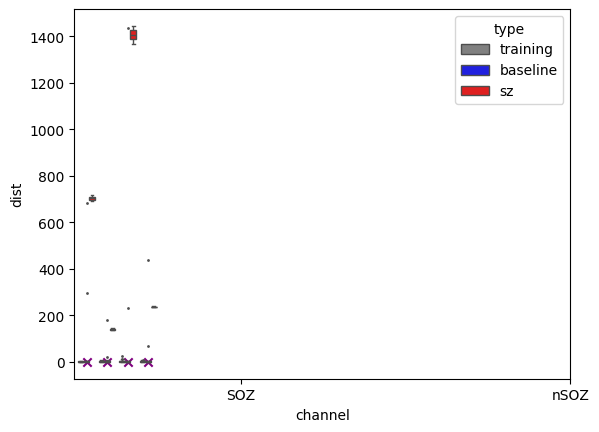

In [38]:
train_mask = (prob_times <= 10)
train_df = pd.DataFrame(mahalanobis[train_mask],columns=data.columns)
gen_mask = (prob_times <= sz_start) & (prob_times > 10)
gen_df = pd.DataFrame(mahalanobis[gen_mask],columns=data.columns)
sz_mask = (prob_times <= sz_start+1) & (prob_times > sz_start)
sz_df = pd.DataFrame(mahalanobis[sz_mask],columns=data.columns)
train_df['type'] = 'training'
gen_df['type'] = 'baseline'
sz_df['type'] = 'sz'
df = pd.concat([train_df,gen_df,sz_df])
df = df.melt(id_vars=['type'],var_name='channel',value_name='dist')
sns.boxplot(data=df,x='channel',y='dist',hue='type',palette=['gray','blue','red'],flierprops={'markersize':1})
plt.scatter(list(range(gen_df.shape[1]-1)), gen_df.iloc[:,:-1].quantile(0.05),color='purple',marker='x')
plt.xticks([7.5,23.5],['SOZ','nSOZ'])
plt.show()

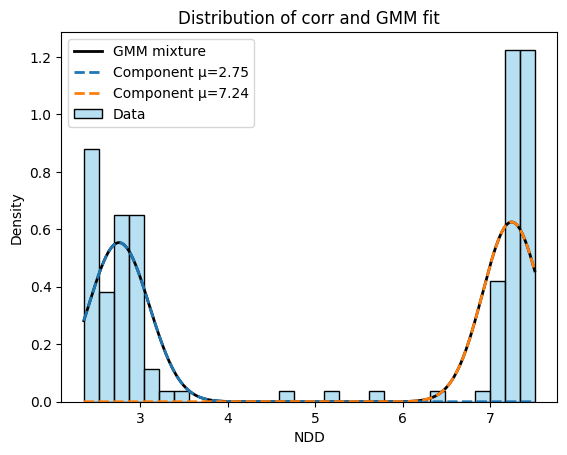

In [15]:
from sklearn.mixture import GaussianMixture
import numpy as np

y = sc.ndimage.median_filter(np.log(ndd.loc[~train_mask,].copy()),size=20,mode='nearest',axes=0)
for i in range(y.shape[1]):
    x = y[:,i]
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(x.reshape(-1,1))

    # Plot the histogram of the data
    sns.histplot(x.flatten(), bins=30, stat='density', color='skyblue', label='Data', alpha=0.6)

    # Plot the estimated Gaussian components
    x = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)  # Score for each x, repeated for 8 channels
    pdf = np.exp(logprob)
    plt.plot(x, pdf, color='black', lw=2, label='GMM mixture')

    # Plot each component
    means = gmm.means_.flatten()
    covars = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_.flatten()
    for mean, covar, weight in zip(means, covars, weights):
        component_pdf = weight * (1/(np.sqrt(2*np.pi)*covar)) * np.exp(-0.5*((x-mean)/covar)**2)
        plt.plot(x, component_pdf, lw=2, linestyle='--', label=f'Component μ={mean:.2f}')

    plt.legend()
    plt.xlabel('NDD')
    plt.ylabel('Density')
    plt.title('Distribution of corr and GMM fit')
    plt.show()
    break

In [ ]:
sequence_length = 16
forecast_length = 1
# model = GIN(num_epochs=100,batch_size=128,sequence_length = sequence_length,forecast_length=forecast_length,hidden_size=sequence_length*data.shape[1],early_stopping=True, num_layers=1,lr=0.0005,w_stride=0.5,w_size=1,patience=3)
model = LiRNDDA(num_epochs=200,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,hidden_size=2*data.shape[1],early_stopping=True, num_layers=2,lr=0.0005,w_stride=0.125,w_size=1,patience=3)

# model = LiNDDA(num_epochs=200,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,early_stopping=True,lr=0.0005,w_stride=0.125,w_size=1,val_split=0.1)
# model = MINDD(num_epochs=100,batch_size=32,sequence_length = sequence_length,forecast_length=forecast_length,early_stopping=True,lr=0.0001,dropout=0.2,hidden_sizes=[sequence_length*data.shape[1]],w_stride=0.125,w_size=1,patience=3,)
model.fit(data.iloc[:fs*10,:])
ndd = model(data)
prob_times = model.get_win_times(len(data))


  Model: MultiStepLinearRNN(
  (layers): ModuleList(
    (0): LinearRNNLayer(
      (input_linear): Linear(in_features=32, out_features=64, bias=True)
      (hidden_linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (1): LinearRNNLayer(
      (input_linear): Linear(in_features=64, out_features=64, bias=True)
      (hidden_linear): Linear(in_features=64, out_features=64, bias=False)
    )
  )
  (input_stack): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (input_projection): Linear(in_features=32, out_features=32, bias=True)
  (projection): Linear(in_features=64, out_features=32, bias=True)
)
Training MultiStepLinearRNN model:
  Sequence length: 16, Forecast length: 1
  Early stopping: True
  Model parameters: 18,723
  DataLoader workers: 8
Creating 2544 non-overlapping sequences from continuous data
  Training sequences: 2036, Validation seq

Training:  28%|██▊       | 57/200 [00:18<00:46,  3.08it/s, train_loss=0.0728, val_loss=0.0936, patience=0]


KeyboardInterrupt: 

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::sys

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe


In [17]:
g =np.log(model.get_threshold(ndd.iloc[train_idx:,:],method='medianover'))
_,sz_clf = model.get_onset_and_spread(ndd.iloc[:,:],ret_smooth_mat=True)
print(g)

5.825551799440926


[19.5] [19.5]


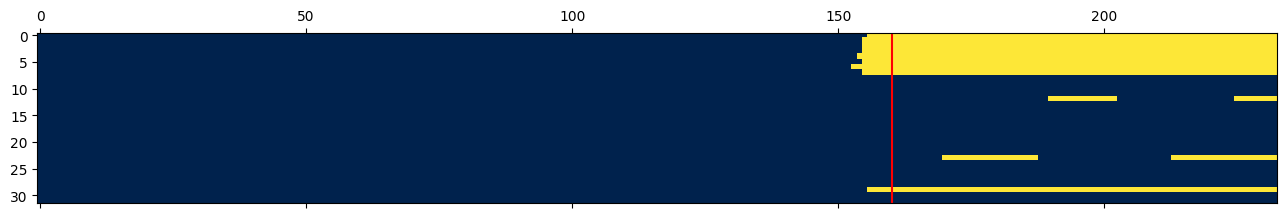

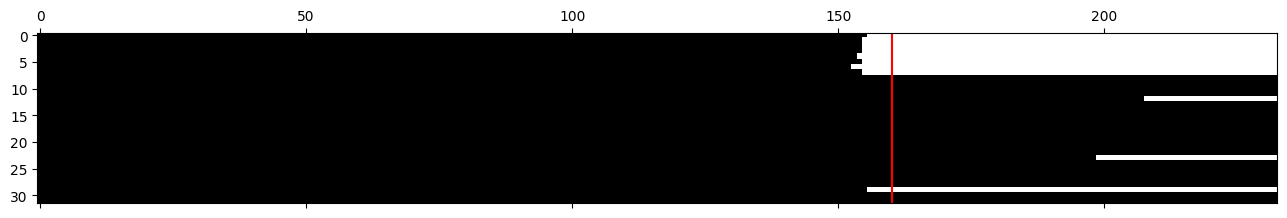

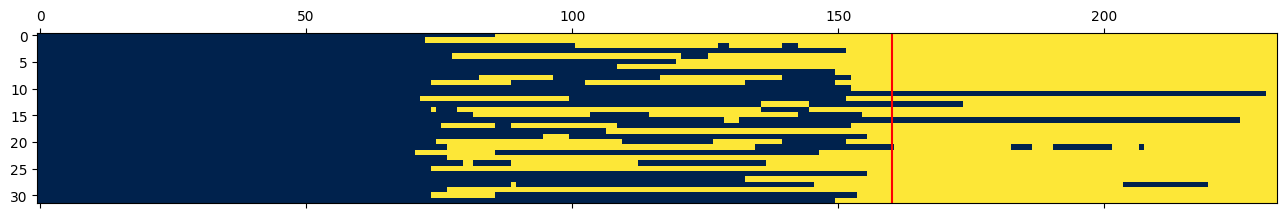

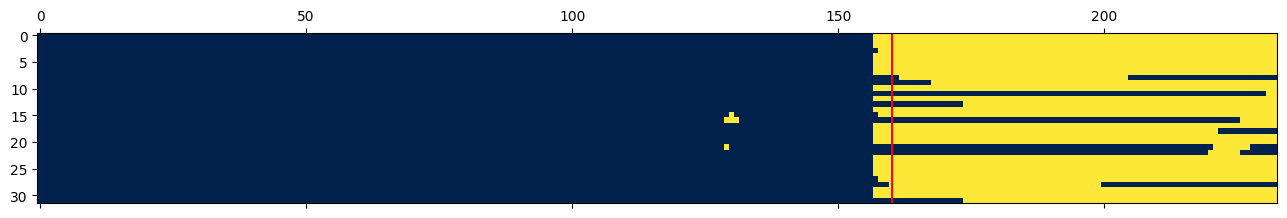

In [22]:
onset_idx = np.argmin(np.abs(prob_times-sz_start))
x = sc.ndimage.median_filter(np.log(ndd.iloc[:,0]),size=20,mode='nearest')
y = sz_clf.iloc[:,0]
prob_start = np.argwhere(x > g)[0]
clf_start = np.argwhere(y)[0]
print(prob_times[prob_start],prob_times[clf_start])

plt.matshow(sc.ndimage.median_filter(np.log(ndd.copy()),size=20,mode='nearest',axes=0).T>g)
plt.axvline(x=onset_idx,color='r')

plt.matshow(sz_clf.T,cmap='gray')
plt.axvline(x=onset_idx,color='r')

plt.matshow(sc.ndimage.median_filter(np.sqrt(ndd.copy()),size=20,mode='nearest',axes=0).T>np.sqrt(10.597))
plt.axvline(x=onset_idx,color='r')

gen_mask = (prob_times <= sz_start) & (prob_times > 10)
t = np.percentile(sc.ndimage.median_filter(np.log(ndd.loc[gen_mask,].copy()),size=20,mode='nearest',axes=0),95,axis=0)
plt.matshow(sc.ndimage.median_filter(np.log(ndd.copy()),size=20,mode='nearest',axes=0).T>t.reshape(-1,1))
plt.axvline(x=onset_idx,color='r')

In [23]:
clf = IMPRINT(fs=fs)
clf.fit(data.iloc[:fs*10,:])
imp_thresh = clf.get_threshold()
imp = clf(data)
imp_times = clf.get_win_times(len(data))

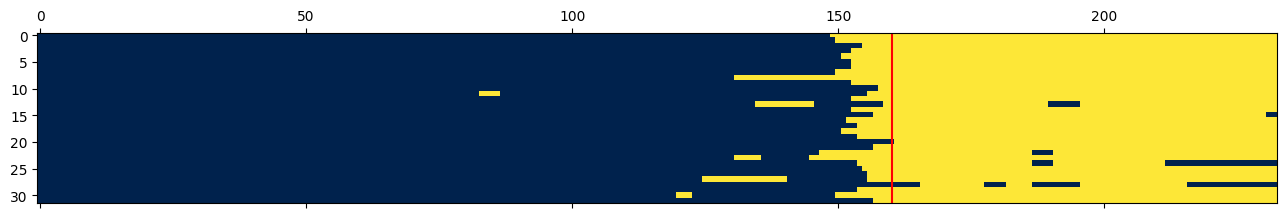

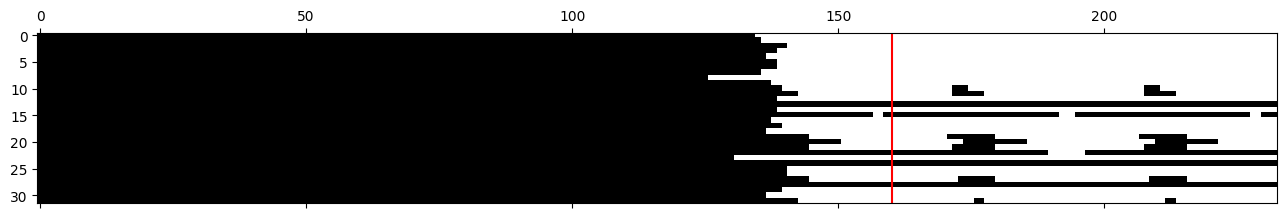

In [24]:
plt.matshow(sc.ndimage.median_filter(imp,size=20,mode='nearest',axes=0).T>imp_thresh)
imp_onset_idx = np.argmin(np.abs(imp_times-sz_start))
plt.axvline(x=imp_onset_idx,color='r')
_,imp_sz_clf = clf.get_onset_and_spread(imp.iloc[:,:],ret_smooth_mat=True)
plt.matshow(imp_sz_clf.T,cmap='gray')
plt.axvline(x=imp_onset_idx,color='r')

In [25]:
wvnt = WVNT(w_size=1,w_stride=0.125,verbose=False,batch_size=512)
wvnt.fit(data.iloc[:fs*10,:])
wave = wvnt(data)
plt.matshow(sc.ndimage.median_filter(wave,size=20,mode='nearest',axes=0).T)

ValueError: Error loading WaveNet model: [Errno 2] Unable to synchronously open file (unable to open file: name = '../checkpoints/WaveNet/v111.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

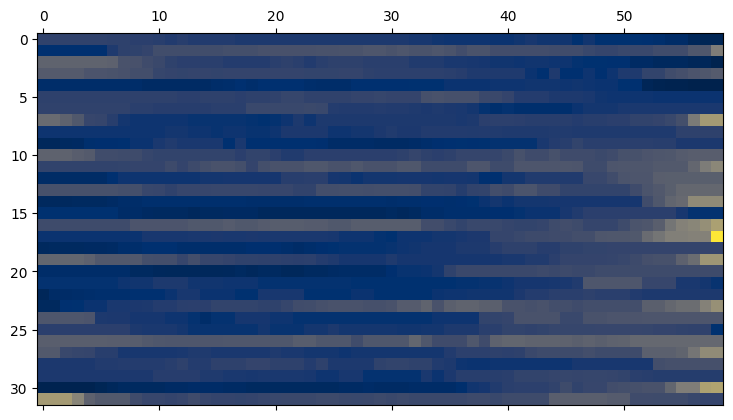

In [26]:
clf = HFER(fs=fs)
clf.fit(data.iloc[:fs*10,:])
sz_prob = clf(data)
plt.matshow(sc.ndimage.median_filter(sz_prob,size=20,mode='nearest',axes=0).T)